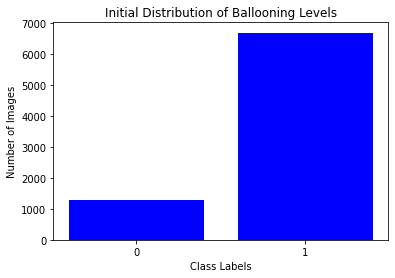

Found 1273 images belonging to 1 classes.


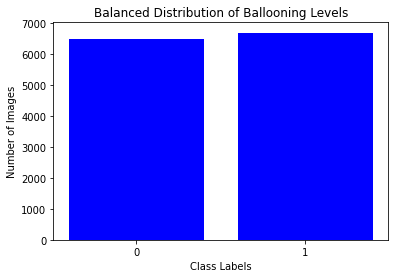

In [1]:
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Paths
data_dir = "D:/DATASET/CNN/ballooning/train"  # Original dataset directory
oversampled_data_dir = 'D:/DATASET/CNN/ballooning/balanced_train'  # Directory for oversampled dataset

# Create oversampled_data directory and subdirectories for each class
os.makedirs(oversampled_data_dir, exist_ok=True)
classes = ['0', '1']  # Ballooning binary classification: 0 and 1
for cls in classes:
    os.makedirs(os.path.join(oversampled_data_dir, cls), exist_ok=True)

def count_images_in_directory(directory):
    """Counts the images in each subdirectory of a given directory."""
    return {folder_name: len(os.listdir(os.path.join(directory, folder_name)))
            for folder_name in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder_name))}

# Count and plot initial distribution
initial_counts = count_images_in_directory(data_dir)

def plot_distribution(data, title):
    """Plots the distribution of data classes."""
    classes = sorted(data.keys())
    counts = [data[cls] for cls in classes]
    plt.bar(classes, counts, color='blue')
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.show()

plot_distribution(initial_counts, 'Initial Distribution of Ballooning Levels')

# We want to oversample class '0' to approximately match the number of images in class '1' (6,500 target)
target_samples = 6500

# Data augmentation setup for oversampling
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def resample_class_images(class_id):
    """Resamples images by class: oversampling or undersampling to target_samples."""
    class_dir = os.path.join(data_dir, class_id)
    target_dir = os.path.join(oversampled_data_dir, class_id)
    images = os.listdir(class_dir)
    current_count = len(images)

    if current_count > target_samples:  # In case we need to undersample (not needed here)
        selected_images = np.random.choice(images, target_samples, replace=False)
    else:  # Oversampling
        selected_images = images  # Include all original images
        # Augment data to reach target count
        augmentation_count = target_samples - current_count
        generator = datagen.flow_from_directory(
            directory=data_dir,
            classes=[class_id],
            target_size=(299, 299),
            batch_size=1,
            save_to_dir=target_dir,
            save_prefix='aug',
            save_format='jpeg'
        )
        for _ in range(augmentation_count):
            generator.next()

    # Copy selected images to oversampled_data
    for img in selected_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(target_dir, img))

# Resample only class '0' (the minority class)
resample_class_images('0')

# Copy class '1' images as is without oversampling
for img in os.listdir(os.path.join(data_dir, '1')):
    shutil.copy(os.path.join(data_dir, '1', img), os.path.join(oversampled_data_dir, '1', img))

# Count and plot balanced distribution
balanced_counts = count_images_in_directory(oversampled_data_dir)
plot_distribution(balanced_counts, 'Balanced Distribution of Ballooning Levels')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
import os

# Define preprocessing function
def preprocess_image(image):
    # Convert to grayscale (assuming image is loaded in color)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian Blur
    image = cv2.GaussianBlur(image, (5, 5), 0)
    # Expand the dimensions to fit model input
    return np.stack((image,)*3, axis=-1)  # Stack grayscale image to have three channels

# Configure data generator
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rescale=1./255
)

# Setting up paths and parameters
train_data_path = "D:/DATASET/CNN/ballooning/train"

train_generator = datagen.flow_from_directory(
    train_data_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

In [ ]:
num_threads = 4  # Use all cores available on each node
#os.environ['TF_NUM_INTRAOP_THREADS'] = str(num_threads)
#os.environ['TF_NUM_INTEROP_THREADS'] = str(num_threads)
print(os.cpu_count())

In [ ]:
# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [ ]:
# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train model
history = model.fit(train_generator, epochs=5)

In [ ]:
# Predict on 299x299 dimension images to check the model performance

import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_single_image(image_path, model):
    # Load the image
    image = cv2.imread(image_path)
    
    # Preprocess the image
    processed_image = preprocess_image(image)
    processed_image = np.expand_dims(processed_image, axis=0)  # Add batch dimension
    
    # Predict the ballooning score
    score = model.predict(processed_image)[0]
    
    # Display the image and its predicted score
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.title(f'Predicted Ballooning Score: {score[0]:.2f}')
    plt.axis('off')  # Hide axes
    plt.show()
    
    return score

In [ ]:
image_path = "D:/DATASET/CNN/ballooning/train/1/8_179_37.png"
score = predict_single_image(image_path, model)
print ("BALLOONING SCORE: ", score)

In [ ]:
# Save the model
model.save('D:/DATASET/Models/model_ballooning.h5')

In [ ]:
# Predict on Large images 1853x932 dimension

import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_and_visualize(image_path, model):
    image = cv2.imread(image_path)
    step_size = 299  # Since target size during training is 299x299
    scores = []
    fig, ax = plt.subplots(nrows=int(np.ceil((image.shape[0]-step_size)/step_size)), ncols=int(np.ceil((image.shape[1]-step_size)/step_size)), figsize=(20, 10))

    idx = 0
    for y in range(0, image.shape[0] - step_size, step_size):
        for x in range(0, image.shape[1] - step_size, step_size):
            crop = image[y:y+step_size, x:x+step_size]
            processed_crop = preprocess_image(crop)
            processed_crop = np.expand_dims(processed_crop, axis=0)
            score = model.predict(processed_crop)[0]
            scores.append(score)
            
            # Plotting the crop with its score
            ax_idx = np.unravel_index(idx, ax.shape)
            ax[ax_idx].imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            ax[ax_idx].title.set_text(f'Score: {score[0]:.2f}')
            ax[ax_idx].axis('off')
            idx += 1

    plt.tight_layout()
    plt.show()

    average_score = np.mean(scores)
    print(f'Average ballooning score for the image: {average_score}')

    return scores, average_score


In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()